# Figs of WMT tendency terms
## Table Of Contents: <a class="anchor" id="top"> </a>
* [Annual-mean global fig of each term](#first-bullet)
* [Global timeseries of each term](#second-bullet)

> Note: the time dimension is only for first 6 months of CESM data

In [5]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [6]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.a612c4094cec46aa81588485c92b9e1d/status,


In [36]:
cluster.close()
client.close()

In [2]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
import pop_tools
import gcsfs
from xhistogram.xarray import histogram

In [3]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [15]:
import json
with open('/home/jovyan/chapter2/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tendencies.zarr')).drop(('nlat', 'nlon'))
#histograms = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/histograms.zarr'))
#histograms

In [16]:
tendencies

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [44]:
rho = xr.apply_ufunc(jmd95numba.rho, ds.SSS, ds.SST, 0,
                        output_dtypes=[ds.SST.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())
rho0 = rho.isel(time=0)

In [9]:
rho = rho.isel(time=slice(0,182))

In [10]:
vol = ds.TAREA * ds.dz
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [37]:
tendency_terms = xr.merge([(tendencies.SST_bih*tendencies.drhodt).rename('sst'), 
                           (tendencies.SSS_bih*tendencies.drhods).rename('sss'), 
                            tendencies.rho_bih.rename('rho'), 
                            tendencies.cabbeling.rename('cabbeling')])
tendency0 = tendency_terms.isel(time=0)

In [38]:
all_tendencies = list(tendency0)

In [45]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho0.rename('rho0'), bins=[rho_bins],
                     weights=variable.fillna(0.), dim=['nlon', 'nlat'])
    return hist / delta_rho

In [46]:
histograms = xr.merge([histogram_func(tendency0[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])

In [47]:
histograms

<xarray.Dataset>
Dimensions:          (rho0_bin: 1499)
Coordinates:
  * rho0_bin         (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst        (rho0_bin) float32 dask.array<chunksize=(1499,), meta=np.ndarray>
    OMEGA_sss        (rho0_bin) float32 dask.array<chunksize=(1499,), meta=np.ndarray>
    OMEGA_rho        (rho0_bin) float32 dask.array<chunksize=(1499,), meta=np.ndarray>
    OMEGA_cabbeling  (rho0_bin) float32 dask.array<chunksize=(1499,), meta=np.ndarray>

# 1) Annual-mean global fig <a class='anchor' id='first-bullet'> </a>
(use logarithmic scale on y-axis)

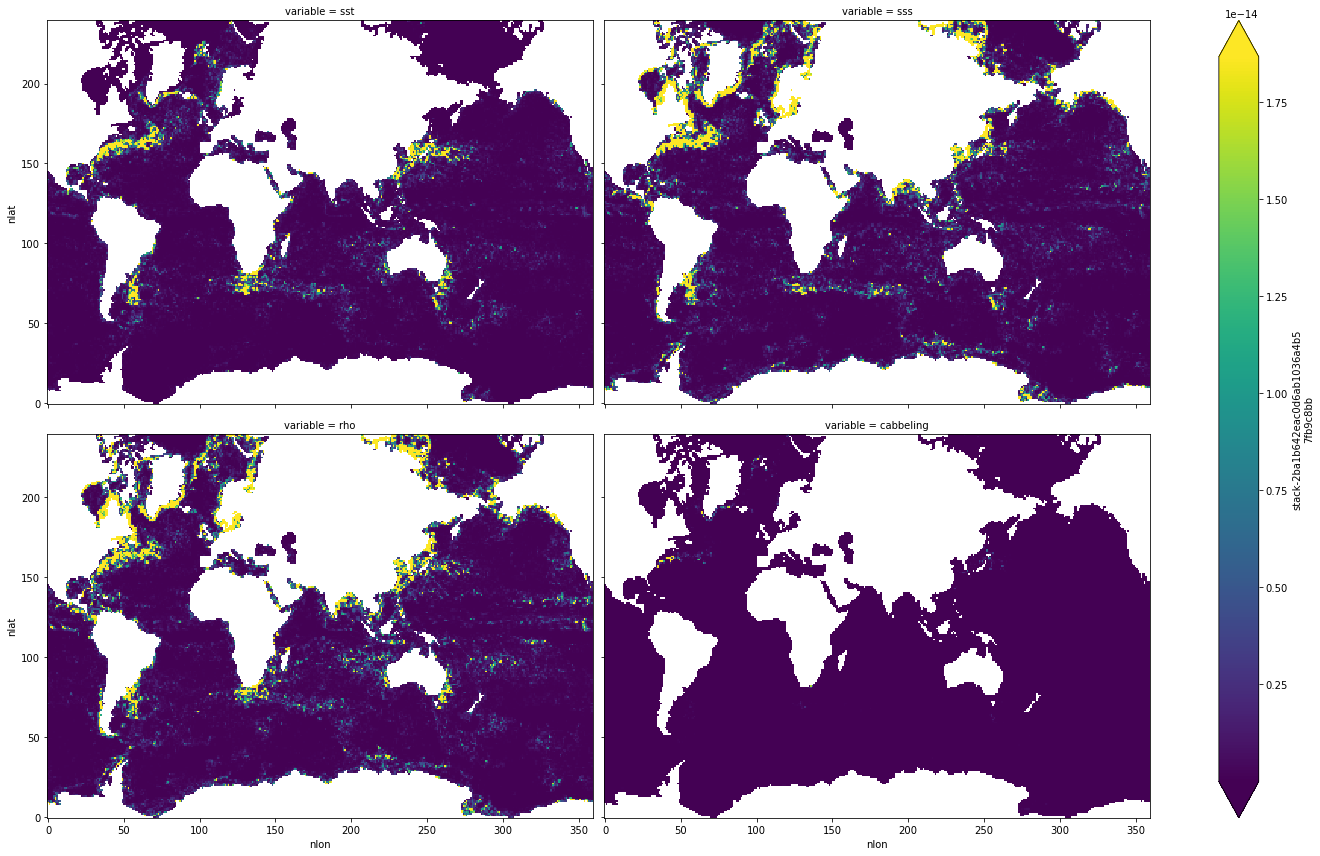

In [49]:
(tendency_terms.isel(time=0)**2).coarsen(nlon=10, 
                                         nlat=10).mean().to_array().plot(col='variable', 
                                                                         col_wrap=2, robust=True, 
                                                                         figsize=(20, 12))

# 2) Global timeseries fig <a class='anchor' id='second-bullet'> </a>
(use logarithmic scale on y-axis)